In [68]:
# ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pandas_profiling

In [70]:
import math, time, random, datetime

# data analysis and wrangling
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

In [71]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#import for interactive plotting
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
%matplotlib inline

In [72]:
# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler

In [73]:
# machine learning
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron,SGDClassifier,LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold, GridSearchCV, learning_curve, cross_val_score

# Import and Inspect Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Stage 3/Dataset FinPro.csv')

In [ ]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [ ]:
df.shape

(1470, 35)

# Data Summary

In [ ]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
df['Attrition'] = df['Attrition'].apply(lambda x:1 if x == "Yes" else 0 )
df['OverTime'] = df['OverTime'].apply(lambda x:1 if x =="Yes" else 0 )

In [ ]:
# Define visualization for categorical features

def categorical_column_viz(col_name):
    f, ax = plt.subplots(1, 2, figsize=(10, 6))

    # Count Plot
    df[col_name].value_counts().plot.bar(cmap='Set1', ax=ax[0])
    ax[0].set_title(f'Number of Employee by {col_name}')
    ax[0].set_ylabel('Count')
    ax[0].set_xlabel(f'{col_name}')

    # Attrition Count per factors
    sns.countplot(x=col_name, hue='Attrition', data=df, ax=ax[1], palette='Set1')
    ax[1].set_title(f'Attrition by {col_name}')
    ax[1].set_xlabel(f'{col_name}')
    ax[1].set_ylabel('Count')

In [ ]:
# Define visualization for numerical features

def numerical_column_viz(col_name):
    f,ax = plt.subplots(1,2, figsize=(18,6))
    sns.kdeplot(attrition[col_name], label='Employee who left',ax=ax[0], shade=True, color='palegreen')
    sns.kdeplot(no_attrition[col_name], label='Employee who stayed', ax=ax[0], shade=True, color='salmon')

    sns.boxplot(y=col_name, x='Attrition',data=df, palette='Set3', ax=ax[1])

## Extracting Features

In [ ]:
# drop the unnecessary columns (based EDA Stage 1)
df.drop(['EmployeeNumber','Over18','StandardHours','EmployeeCount'],axis=1,inplace=True)

In [ ]:
df.info()

In [ ]:
# 'EnviornmentSatisfaction', 'JobInvolvement', 'JobSatisfacction', 'RelationshipSatisfaction', 'WorklifeBalance' can be clubbed into a single feature 'Accumulated_Satisfaction'

df['Accumulated_Satisfaction'] = (df['EnvironmentSatisfaction'] +
                            df['JobInvolvement'] +
                            df['JobSatisfaction'] +
                            df['RelationshipSatisfaction'] +
                            df['WorkLifeBalance']) /5

In [ ]:
attrition = df[df['Attrition'] == 1]
no_attrition = df[df['Attrition']==0]

In [ ]:
numerical_column_viz('Accumulated_Satisfaction')

In [ ]:
df.Accumulated_Satisfaction.describe()

In [ ]:
df.corr()

In [ ]:
# Because Accumulated_Satisfaction has higher correlation to Attrition compared to its constituents, then we consider to drop them all

df.drop(['EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'RelationshipSatisfaction', 'WorkLifeBalance'],axis=1,inplace=True)

In [ ]:
df.info()

In [ ]:
# Extract new feature #2 'YearsWorkingPerCompany'

df['YearsWorkingPerCompany'] = df['TotalWorkingYears'] / df['NumCompaniesWorked']
df.head()

In [ ]:
df['YearsWorkingPerCompany'].describe()

In [ ]:
df.info()

In [ ]:
# Karena terdapat data pada fitur YearsWorkingPerCompany berupa inf, maka akan dilakukan modif pada fitur NumCompaniesWorked, TotalWorkingYears, dan YearsAtCOmpany

df.drop(df[(df['NumCompaniesWorked'] == 0) & (df['YearsAtCompany'] != df['TotalWorkingYears'])].index, axis=0, inplace=True)


In [ ]:
df.info()

In [ ]:
df['YearsWorkingPerCompany'].describe()

In [ ]:
attrition = df[df['Attrition'] == 1]
no_attrition = df[df['Attrition']==0]

In [ ]:
numerical_column_viz('YearsWorkingPerCompany')

## Data Cleansing

Berdasarkan EDA (Stage 1) sebelumnya, maka akan dilakukan data cleansing sebagai berikut :

1. Missing value: There's **no missing value in dataset**
2. Duplicates: There's **no duplicates in dataset**
3. Handle Outliers: **handling outlier with zscore > 3**
4. Feature transformation: **perform transfor log1p for positiveskewed distribution features**

In [ ]:
#Transform Possitively Skewed Features
positively_skewed_features = ['DistanceFromHome', 'MonthlyIncome', 'TotalWorkingYears',
                         'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager','PercentSalaryHike', 'YearsWorkingPerCompany']

# Log-transform the positively skewed features
for feature in positively_skewed_features:
    df[feature] = np.log1p(df[feature])

# Check the resulting DataFrame
print(df.head())

In [ ]:
df[positively_skewed_features].describe()

### Handling Outliers

In [ ]:
# Step 1: Calculate Z-scores for each feature
z_scores = pd.DataFrame()
for col in df.columns:
    if df[col].dtype in [int, float]:
        z_scores[col] = (df[col] - df[col].mean()) / df[col].std()

# Step 2: Identify rows with Z-scores greater than a threshold (e.g., 3 or -3)
threshold = 3
outlier_flags_zscore = (z_scores.abs() > threshold).any(axis=1)

# Step 3: Calculate the IQR for each feature
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3 - q1

# Step 4: Define the upper and lower bounds for outliers using IQR method
lower_bound_iqr = q1 - 1.5 * iqr
upper_bound_iqr = q3 + 1.5 * iqr

# Step 5: Identify rows with values outside the bounds (IQR method)
outlier_flags_iqr = ((df < lower_bound_iqr) | (df > upper_bound_iqr)).any(axis=1)

# Check the number of rows before and after handling outliers for both techniques
print("Number of rows before handling outliers (Original):", len(df))
print("Number of rows after handling outliers (Z-score method):", len(df[~outlier_flags_zscore]))
print("Number of rows after handling outliers (IQR method):", len(df[~outlier_flags_iqr]))

**Decided to use z-score method**

In [ ]:
# Remove the rows with flagged Z-scores (outliers)
df = df[~outlier_flags_zscore]

# Check the resulting DataFrame after removing outliers
print(df.head())

In [ ]:
df.describe()

### Encode Categorical Features

In [ ]:
# We will encode the selected categorical features

features_to_onehot_encode = ['BusinessTravel', 'Department', 'EducationField',
                            'MaritalStatus', 'JobRole']

# One-hot encode the selected features
df = pd.get_dummies(df, columns=features_to_onehot_encode)
df.head()

In [ ]:
df['Gender'] = df['Gender'].apply(lambda x:1 if x =="Male" else 0 )

In [ ]:
df.sample(10)

In [ ]:
df.describe()

In [ ]:
df.info()

### Split Data Train & Test

In [ ]:
from sklearn.model_selection import train_test_split

# Separate the target variable from the features
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Check the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

### Scale Data Train & Test

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing set using the same scaling
X_test_scaled = scaler.transform(X_test)

# Check the scaled data
print("X_train_scaled:\n", X_train_scaled)
print("X_test_scaled:\n", X_test_scaled)

### Handle Imbalance Class

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Check class distribution before oversampling
print("Before oversampling:", Counter(y_train))

# Initialize the RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Fit and apply the oversampler only to the training set
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_scaled, y_train)

# Check class distribution after oversampling
print("After oversampling:", Counter(y_train_resampled))

### Feature Selection

In [117]:
# Convert the X_train_resampled array back to a DataFrame
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)

# Calculate the correlation between each feature and the target variable 'Attrition'
correlations = X_train_resampled_df.corrwith(y_train_resampled)

# Filter features based on correlation threshold
correlation_threshold = 0.07
selected_features = correlations[(correlations > correlation_threshold) | (correlations < -correlation_threshold)]

# Print the selected features and their correlations with 'Attrition'
print(selected_features)

Age                                 -0.188209
DailyRate                           -0.102016
DistanceFromHome                     0.094112
JobLevel                            -0.244937
MonthlyIncome                       -0.277302
OverTime                             0.295762
StockOptionLevel                    -0.142361
TotalWorkingYears                   -0.292519
TrainingTimesLastYear               -0.081083
YearsAtCompany                      -0.242391
YearsInCurrentRole                  -0.216552
YearsWithCurrManager                -0.231257
Accumulated_Satisfaction            -0.269434
YearsWorkingPerCompany              -0.268648
BusinessTravel_Non-Travel           -0.151371
BusinessTravel_Travel_Frequently     0.214879
BusinessTravel_Travel_Rarely        -0.114497
Department_Research & Development   -0.130844
Department_Sales                     0.139799
MaritalStatus_Divorced              -0.128017
MaritalStatus_Married               -0.091326
MaritalStatus_Single              

### Recommendation Feature Outside This Dataset

**Recommendations:**
1. Performance Feedback: Frequency and quality of feedback received by the employee.
2. Job Stability: The stability or likelihood of future job changes.
3. Career Growth Opportunities: The perceived potential for career advancement within the company.
4. Company Culture: Employee perceptions of the overall company culture and values.
5. Employee Engagement: The level of employee commitment and emotional attachment to the organization.

## Train Data

In [74]:
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

# Function that runs the requested algorithm and returns the precision and recall metrics
def fit_ml_algo_for_precision(algo, X_train, y_train, cv):

    # One Pass
    model = algo.fit(X_train, y_train)
    precision = round(metrics.precision_score(y_train, model.predict(X_train)) * 100, 2)

    # Cross Validation
    train_pred = cross_val_predict(algo, X_train, y_train, cv=cv, n_jobs=-1)

    # Cross-validation precision and recall metrics
    precision_cv = round(metrics.precision_score(y_train, train_pred) * 100, 2)

    return train_pred, precision, precision_cv

### Logistic Regression

In [75]:
# Logistic Regression
selected_feature_indices = [list(X_train.columns).index(feature) for feature in selected_features.index]

X_train_selected = X_train_resampled[:, selected_feature_indices]

start_time = time.time()
train_pred_log, precision_log, precision_cv_log = fit_ml_algo_for_precision(LogisticRegression(), X_train_selected, y_train_resampled, 10)
log_time = (time.time() - start_time)

print("Precision: %s" % precision_log)
print("Precision CV 10-Fold: %s" % precision_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Precision: 77.32
Precision CV 10-Fold: 75.96
Running Time: 0:00:02.140881


### Support Vector Machine

In [104]:
# SVC
selected_feature_indices = [list(X_train.columns).index(feature) for feature in selected_features.index]

X_train_selected = X_train_resampled[:, selected_feature_indices]

start_time = time.time()
train_pred_svc, precision_svc, precision_cv_svc = fit_ml_algo_for_precision(SVC(), X_train_selected, y_train_resampled, 10)
svc_time = (time.time() - start_time)

print("Precision (SVC): %s" % precision_svc)
print("Precision CV 10-Fold (SVC): %s" % precision_cv_svc)
print("Running Time (SVC): %s" % datetime.timedelta(seconds=svc_time))

Precision (SVC): 87.12
Precision CV 10-Fold (SVC): 82.53
Running Time (SVC): 0:00:02.489242


### Linear Support Vector Machines

In [105]:
# Linear SVC
selected_feature_indices = [list(X_train.columns).index(feature) for feature in selected_features.index]

X_train_selected = X_train_resampled[:, selected_feature_indices]

start_time = time.time()
train_pred_linear_svc, precision_linear_svc, precision_cv_linear_svc = fit_ml_algo_for_precision(LinearSVC(), X_train_selected, y_train_resampled, 10)
linear_svc_time = (time.time() - start_time)

print("Precision (LinearSVC): %s" % precision_linear_svc)
print("Precision CV 10-Fold (LinearSVC): %s" % precision_cv_linear_svc)
print("Running Time (LinearSVC): %s" % datetime.timedelta(seconds=linear_svc_time))

Precision (LinearSVC): 76.5
Precision CV 10-Fold (LinearSVC): 76.01
Running Time (LinearSVC): 0:00:00.537597


### K Nearest Neighbour

In [106]:
# K Nearest Neighbour
selected_feature_indices = [list(X_train.columns).index(feature) for feature in selected_features.index]

X_train_selected = X_train_resampled[:, selected_feature_indices]

start_time = time.time()
train_pred_knn, precision_knn, precision_cv_knn = fit_ml_algo_for_precision(KNeighborsClassifier(n_neighbors=3), X_train_selected, y_train_resampled, 10)
knn_time = (time.time() - start_time)

print("Precision (KNeighborsClassifier): %s" % precision_knn)
print("Precision CV 10-Fold (KNeighborsClassifier): %s" % precision_cv_knn)
print("Running Time (KNeighborsClassifier): %s" % datetime.timedelta(seconds=knn_time))

Precision (KNeighborsClassifier): 90.64
Precision CV 10-Fold (KNeighborsClassifier): 82.89
Running Time (KNeighborsClassifier): 0:00:00.240037


### Gaussian Naive Bayes

In [107]:
# Gaussian Naive Bayes
selected_feature_indices = [list(X_train.columns).index(feature) for feature in selected_features.index]

X_train_selected = X_train_resampled[:, selected_feature_indices]

start_time = time.time()
train_pred_gaussian, precision_gaussian, precision_cv_gaussian = fit_ml_algo_for_precision(GaussianNB(), X_train_selected, y_train_resampled, 10)
gaussian_time = (time.time() - start_time)

print("Precision (GaussianNB): %s" % precision_gaussian)
print("Precision CV 10-Fold (GaussianNB): %s" % precision_cv_gaussian)
print("Running Time (GaussianNB): %s" % datetime.timedelta(seconds=gaussian_time))

Precision (GaussianNB): 58.06
Precision CV 10-Fold (GaussianNB): 58.13
Running Time (GaussianNB): 0:00:00.066190


### Perceptron

In [108]:
# Perceptron
selected_feature_indices = [list(X_train.columns).index(feature) for feature in selected_features.index]

X_train_selected = X_train_resampled[:, selected_feature_indices]

start_time = time.time()
train_pred_perceptron, precision_perceptron, precision_cv_perceptron= fit_ml_algo_for_precision(Perceptron(), X_train_selected, y_train_resampled, 10)
perceptron_time = (time.time() - start_time)

print("Precision (Perceptron): %s" % precision_perceptron)
print("Precision CV 10-Fold (Perceptron): %s" % precision_cv_perceptron)
print("Running Time (Perceptron): %s" % datetime.timedelta(seconds=perceptron_time))

Precision (Perceptron): 84.42
Precision CV 10-Fold (Perceptron): 73.46
Running Time (Perceptron): 0:00:00.102068


### Stochastic Gradient Descent

In [109]:
# Stochastic Gradient Descent
selected_feature_indices = [list(X_train.columns).index(feature) for feature in selected_features.index]

X_train_selected = X_train_resampled[:, selected_feature_indices]

start_time = time.time()
train_pred_sgd, precision_sgd, precision_cv_sgd = fit_ml_algo_for_precision(SGDClassifier(), X_train_selected, y_train_resampled, 10)
sgd_time = (time.time() - start_time)

print("Precision (SGDClassifier): %s" % precision_sgd)
print("Precision CV 10-Fold (SGDClassifier): %s" % precision_cv_sgd)
print("Running Time (SGDClassifier): %s" % datetime.timedelta(seconds=sgd_time))

Precision (SGDClassifier): 68.76
Precision CV 10-Fold (SGDClassifier): 73.68
Running Time (SGDClassifier): 0:00:00.155707


### Decision Tree

In [110]:
# Decision Tree
selected_feature_indices = [list(X_train.columns).index(feature) for feature in selected_features.index]

X_train_selected = X_train_resampled[:, selected_feature_indices]

start_time = time.time()
train_pred_dt, precision_dt, precision_cv_dt = fit_ml_algo_for_precision(DecisionTreeClassifier(), X_train_selected, y_train_resampled, 10)
dt_time = (time.time() - start_time)

print("Precision (DecisionTreeClassifier): %s" % precision_dt)
print("Precision CV 10-Fold (DecisionTreeClassifier): %s" % precision_cv_dt)
print("Running Time (DecisionTreeClassifier): %s" % datetime.timedelta(seconds=dt_time))

Precision (DecisionTreeClassifier): 100.0
Precision CV 10-Fold (DecisionTreeClassifier): 88.6
Running Time (DecisionTreeClassifier): 0:00:00.131103


### Gradient Boosting Trees

In [111]:
# Gradient Boosting Trees
selected_feature_indices = [list(X_train.columns).index(feature) for feature in selected_features.index]

X_train_selected = X_train_resampled[:, selected_feature_indices]

start_time = time.time()
train_pred_gbt, precision_gbt, precision_cv_gbt = fit_ml_algo_for_precision(GradientBoostingClassifier(), X_train_selected, y_train_resampled, 10)
gbt_time = (time.time() - start_time)

print("Precision (GradientBoostingClassifier): %s" % precision_gbt)
print("Precision CV 10-Fold (GradientBoostingClassifier): %s" % precision_cv_gbt)
print("Running Time (GradientBoostingClassifier): %s" % datetime.timedelta(seconds=gbt_time))

Precision (GradientBoostingClassifier): 94.67
Precision CV 10-Fold (GradientBoostingClassifier): 89.16
Running Time (GradientBoostingClassifier): 0:00:05.559824


### Random Forest

In [112]:
# Random Forest
selected_feature_indices = [list(X_train.columns).index(feature) for feature in selected_features.index]

X_train_selected = X_train_resampled[:, selected_feature_indices]

start_time = time.time()
train_pred_rf, precision_rf, precision_cv_rf= fit_ml_algo_for_precision(RandomForestClassifier(n_estimators=100), X_train_selected, y_train_resampled, 10)
rf_time = (time.time() - start_time)

print("Precision (RandomForestClassifier): %s" % precision_rf)
print("Precision CV 10-Fold (RandomForestClassifier): %s" % precision_cv_rf)
print("Running Time (RandomForestClassifier): %s" % datetime.timedelta(seconds=rf_time))

Precision (RandomForestClassifier): 100.0
Precision CV 10-Fold (RandomForestClassifier): 96.2
Running Time (RandomForestClassifier): 0:00:02.543887


## Training Model Results

In [113]:
# Create a DataFrame to store model scores
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Linear SVC', 'KNN', 'Naive Bayes', 'Perceptron',
              'Stochastic Gradient Decent', 'Decision Tree', 'Gradient Boosting Trees', 'Random Forest'],
    'Precision Score': [
        precision_log,
        precision_svc,
        precision_linear_svc,
        precision_knn,
        precision_gaussian,
        precision_perceptron,
        precision_sgd,
        precision_dt,
        precision_gbt,
        precision_rf,
    ]
})

# Sort the models by Average Score in descending order
models.sort_values(by='Precision Score', ascending=False, inplace=True)

# Display the sorted DataFrame
print(models)

                        Model  Precision Score
7               Decision Tree           100.00
9               Random Forest           100.00
8     Gradient Boosting Trees            94.67
3                         KNN            90.64
1                         SVM            87.12
5                  Perceptron            84.42
0         Logistic Regression            77.32
2                  Linear SVC            76.50
6  Stochastic Gradient Decent            68.76
4                 Naive Bayes            58.06


In [114]:
# Create a DataFrame to store cross-validated model scores
cv_models = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Linear SVC', 'KNN', 'Naive Bayes', 'Perceptron',
              'Stochastic Gradient Decent', 'Decision Tree', 'Gradient Boosting Trees', 'Random Forest'],
    'Precision CV 10-Fold': [
        precision_cv_log,
        precision_cv_svc,
        precision_cv_linear_svc,
        precision_cv_knn,
        precision_cv_gaussian,
        precision_cv_perceptron,
        precision_cv_sgd,
        precision_cv_dt,
        precision_cv_gbt,
        precision_cv_rf
    ]
})

# Sort the cross-validated models by Precision CV 10-Fold in descending order
cv_models.sort_values(by='Precision CV 10-Fold', ascending=False, inplace=True)

# Display the sorted DataFrame
print(cv_models)

                        Model  Precision CV 10-Fold
9               Random Forest                 96.20
8     Gradient Boosting Trees                 89.16
7               Decision Tree                 88.60
3                         KNN                 82.89
1                         SVM                 82.53
2                  Linear SVC                 76.01
0         Logistic Regression                 75.96
6  Stochastic Gradient Decent                 73.68
5                  Perceptron                 73.46
4                 Naive Bayes                 58.13


# Model Evaluation 1

In [115]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score

# Define a dictionary of models with their default parameters
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Linear SVC': LinearSVC(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting Trees': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Define precision scoring function for cross-validation
precision_scorer = make_scorer(precision_score)

# Evaluate each model using cross-validation for precision
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_selected, y_train_resampled, cv=10, scoring=precision_scorer)
    mean_precision = scores.mean()
    print(f"Model: {model_name}")
    print(f"Precision Scores: {scores}")
    print(f"Mean Precision Score: {mean_precision:.3f}")
    print("-" * 40)

Model: Logistic Regression
Precision Scores: [0.78378378 0.69444444 0.7625     0.78082192 0.734375   0.703125
 0.78571429 0.85483871 0.71014493 0.78666667]
Mean Precision Score: 0.760
----------------------------------------
Model: SVM
Precision Scores: [0.82608696 0.81428571 0.80246914 0.85333333 0.84285714 0.8028169
 0.80519481 0.89393939 0.79710145 0.82278481]
Mean Precision Score: 0.826
----------------------------------------
Model: Linear SVC
Precision Scores: [0.80555556 0.70422535 0.7625     0.78082192 0.72131148 0.67692308
 0.77464789 0.88333333 0.72727273 0.76623377]
Mean Precision Score: 0.760
----------------------------------------
Model: KNN
Precision Scores: [0.79487179 0.7654321  0.77011494 0.77272727 0.75       0.80246914
 0.81176471 0.825      0.7875     0.78823529]
Mean Precision Score: 0.787
----------------------------------------
Model: Decision Tree
Precision Scores: [0.84337349 0.8625     0.8452381  0.87654321 0.91025641 0.8875
 0.91025641 0.89873418 0.91025641 

## Model Evaluation 2

In [116]:
# Define a dictionary of models with their default parameters
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Linear SVC': LinearSVC(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting Trees': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Define precision scoring function for cross-validation
precision_scorer = make_scorer(precision_score)

# Evaluate each model using cross-validation for precision
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_selected, y_train_resampled, cv=10, scoring=precision_scorer)
    mean_precision = scores.mean()
    std_precision = scores.std()
    print(f"Model: {model_name}")
    print(f"Precision Scores: {scores}")
    print(f"Mean Precision Score: {mean_precision:.3f}")
    print(f"Standard Deviation of Precision Scores: {std_precision:.3f}")
    print("-" * 40)

Model: Logistic Regression
Precision Scores: [0.78378378 0.69444444 0.7625     0.78082192 0.734375   0.703125
 0.78571429 0.85483871 0.71014493 0.78666667]
Mean Precision Score: 0.760
Standard Deviation of Precision Scores: 0.047
----------------------------------------
Model: SVM
Precision Scores: [0.82608696 0.81428571 0.80246914 0.85333333 0.84285714 0.8028169
 0.80519481 0.89393939 0.79710145 0.82278481]
Mean Precision Score: 0.826
Standard Deviation of Precision Scores: 0.029
----------------------------------------
Model: Linear SVC
Precision Scores: [0.80555556 0.70422535 0.7625     0.78082192 0.72131148 0.67692308
 0.77464789 0.88333333 0.72727273 0.76623377]
Mean Precision Score: 0.760
Standard Deviation of Precision Scores: 0.055
----------------------------------------
Model: KNN
Precision Scores: [0.79487179 0.7654321  0.77011494 0.77272727 0.75       0.80246914
 0.81176471 0.825      0.7875     0.78823529]
Mean Precision Score: 0.787
Standard Deviation of Precision Scores:

Based on the precision score, model evaluation 1 & model evaluation 2, we decided to **choose model** with **lowest standard deviation of precision score and highest Precision Score**. So, we decided to choose **Random Forest Classifier**.

# Hyperparameter Tuning

In [78]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 20, 30, 40, 50, 60, 100]
}

# Create a Random Forest model
rf_model = RandomForestClassifier()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=10,  # Number of cross-validation folds
    scoring='precision',  # Use precision as the evaluation metric
    n_jobs=-1,  # Use all available CPU cores for parallel processing
    random_state=42  # For reproducibility
)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train_selected, y_train_resampled)

# Print the best parameters and best precision score
print("Best parameters:", random_search.best_params_)
print("Best precision score:", random_search.best_score_)

Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50, 'criterion': 'gini'}
Best precision score: 0.9610206865120349


### Check model using best params

In [79]:
# Select the columns using the selected_feature_indices
X_test_selected = X_test_scaled[:, selected_feature_indices]

In [80]:
# Random Forest

# Define Random Forest hyperparameters
rf_params = {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50, 'criterion': 'gini'}

# Create and fit the Random Forest model with default parameters
rf_model_default = RandomForestClassifier()
rf_model_default.fit(X_train_selected, y_train_resampled)

# Create and fit the Random Forest model with best parameters
rf_model_best = RandomForestClassifier(**rf_params)
rf_model_best.fit(X_train_selected, y_train_resampled)

# Predictions on training data using default and best parameters
train_pred_rf_default = rf_model_default.predict(X_train_selected)
train_pred_rf_best = rf_model_best.predict(X_train_selected)

# Calculate precision scores before using any hyperparameters for training data
precision_rf_default_before_train = precision_score(y_train_resampled, train_pred_rf_default)
precision_cv_rf_default_before_train = precision_score(y_train_resampled, cross_val_predict(rf_model_default, X_train_selected, y_train_resampled, cv=10, n_jobs=-1))

# Calculate precision scores after using best hyperparameters for training data
precision_rf_best_after_train = precision_score(y_train_resampled, train_pred_rf_best)
precision_cv_rf_best_after_train = precision_score(y_train_resampled, cross_val_predict(rf_model_best, X_train_selected, y_train_resampled, cv=10, n_jobs=-1))

print("Random Forest Precision Default Before (Training):", precision_rf_default_before_train)
print("Random Forest Precision CV 10-Fold Default Before (Training):", precision_cv_rf_default_before_train)
print("Random Forest Precision Best After (Training):", precision_rf_best_after_train)
print("Random Forest Precision CV 10-Fold Best After (Training):", precision_cv_rf_best_after_train)

Random Forest Precision Default Before (Training): 1.0
Random Forest Precision CV 10-Fold Default Before (Training): 0.959349593495935
Random Forest Precision Best After (Training): 1.0
Random Forest Precision CV 10-Fold Best After (Training): 0.9528301886792453


In [81]:
# Random Forest Data Test

# Define Random Forest hyperparameters
rf_params = {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50, 'criterion': 'gini'}

# Create and fit the Random Forest model with best parameters
rf_model_best = RandomForestClassifier(**rf_params)
rf_model_best.fit(X_train_selected, y_train_resampled)

# Predictions on test data using best parameters
test_pred_rf_best = rf_model_best.predict(X_test_selected)

# Calculate precision scores after using best hyperparameters for test data
precision_rf_best_after_test = precision_score(y_test, test_pred_rf_best)

# Cross-validation precision metric after using best hyperparameters for test data
precision_cv_rf_best_after_test = cross_val_predict(rf_model_best, X_test_selected, y_test, cv=10, n_jobs=-1)
precision_cv_rf_best_after_test = precision_score(y_test, precision_cv_rf_best_after_test)

print("Random Forest Precision Best After (Test):", precision_rf_best_after_test)
print("Random Forest Precision CV 10-Fold Best After (Test):", precision_cv_rf_best_after_test)

Random Forest Precision Best After (Test): 0.6666666666666666
Random Forest Precision CV 10-Fold Best After (Test): 0.6428571428571429


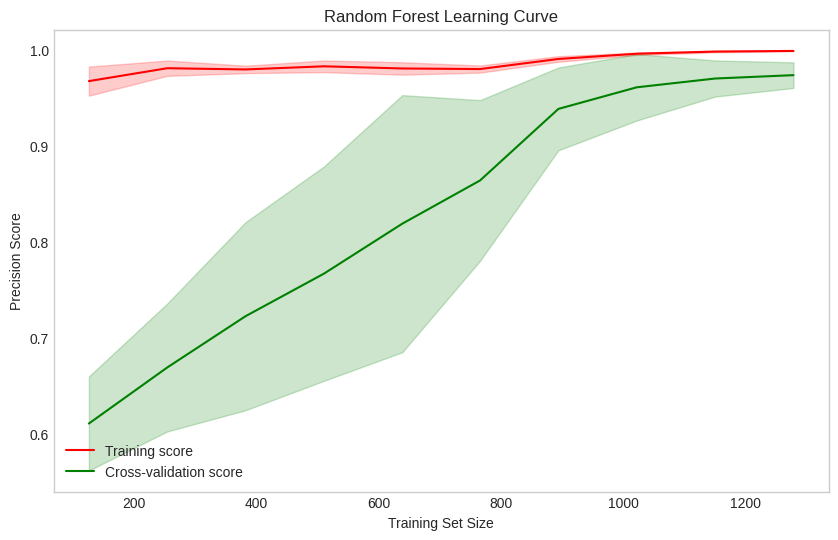

In [82]:
# Learning Curve model RandomForestClassifier

# Create the Random Forest model with best parameters
rf_model_best = RandomForestClassifier(**rf_params)

# Calculate learning curve data
train_sizes, train_scores, cv_scores = learning_curve(rf_model_best, X_train_selected, y_train_resampled, cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation of scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
cv_scores_mean = np.mean(cv_scores, axis=1)
cv_scores_std = np.std(cv_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='r')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='r')
plt.plot(train_sizes, cv_scores_mean, label='Cross-validation score', color='g')
plt.fill_between(train_sizes, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Precision Score')
plt.title('Random Forest Learning Curve')
plt.legend()
plt.grid()
plt.show()

# Predict Data using RandomForest

In [83]:
rf_params = {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50, 'criterion': 'gini'}
model = RandomForestClassifier(**rf_params).fit(X_train, y_train)

In [84]:
predictions = model.predict(X_test)

In [85]:
pred_df = pd.DataFrame(index=X_test.index)

In [86]:
pred_df['Attrition'] = predictions
pred_df.head()

,Attrition
650,0
320,0
55,0
1220,0
909,1


In [87]:
# Cross-validation precision metric
score = round(metrics.precision_score(y_test, predictions) * 100, 2)

In [88]:
print("Precision: %s" % score)

Precision: 80.0


In [89]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       308
           1       0.80      0.14      0.24        58

    accuracy                           0.86       366
   macro avg       0.83      0.57      0.58       366
weighted avg       0.85      0.86      0.81       366



1. Feature: MonthlyIncome, Score: 0.10109
2. Feature: YearsWorkingPerCompany, Score: 0.09413
3. Feature: Accumulated_Satisfaction, Score: 0.08709
4. Feature: Age, Score: 0.08498
5. Feature: DailyRate, Score: 0.07232
6. Feature: OverTime, Score: 0.06828
7. Feature: DistanceFromHome, Score: 0.05947
8. Feature: TotalWorkingYears, Score: 0.05674
9. Feature: YearsAtCompany, Score: 0.04714
10. Feature: YearsWithCurrManager, Score: 0.04364
11. Feature: YearsInCurrentRole, Score: 0.03737
12. Feature: JobLevel, Score: 0.03689
13. Feature: TrainingTimesLastYear, Score: 0.03364
14. Feature: StockOptionLevel, Score: 0.03251
15. Feature: BusinessTravel_Travel_Frequently, Score: 0.02153
16. Feature: MaritalStatus_Single, Score: 0.01420
17. Feature: Department_Research & Development, Score: 0.01361
18. Feature: JobRole_Laboratory Technician, Score: 0.01320
19. Feature: Department_Sales, Score: 0.01300
20. Feature: MaritalStatus_Divorced, Score: 0.01189
21. Feature: MaritalStatus_Married, Score: 0.011

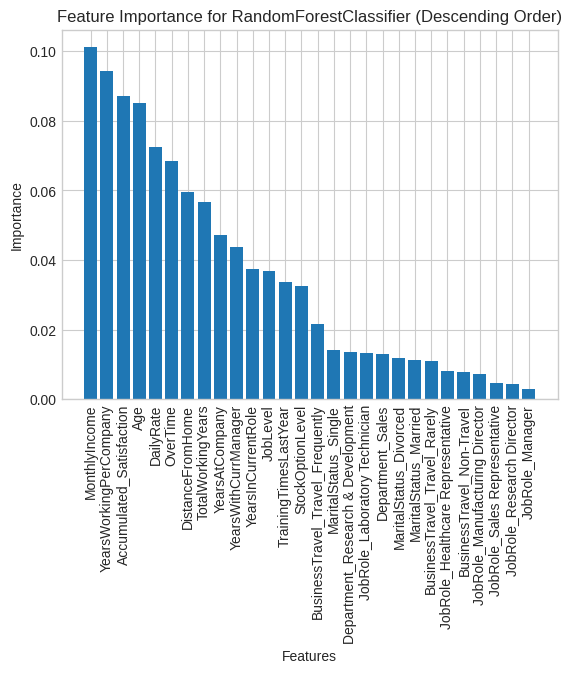

In [93]:
selected_feature_indices = [list(X_train.columns).index(feature) for feature in selected_features.index]

X_train_selected = X_train_resampled[:, selected_feature_indices]

rf_params = {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50, 'criterion': 'gini'}
rf_model = RandomForestClassifier(**rf_params).fit(X_train_selected, y_train_resampled)

importance = rf_model.feature_importances_

sorted_indices = importance.argsort()[::-1]
sorted_importance = importance[sorted_indices]
sorted_features = selected_features.index[sorted_indices]

for i, (feature, score) in enumerate(zip(sorted_features, sorted_importance), 1):
    print(f'{i}. Feature: {feature}, Score: {score:.5f}')

plt.bar(sorted_features, sorted_importance)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance for RandomForestClassifier (Descending Order)")
plt.show()

In [99]:
# Check Model using Top 14 and Top 5 feature

# Select the top 14 and top 5 feature indices
top_14_indices = sorted_indices[:14]
top_5_indices = sorted_indices[:5]
top_3_indices = sorted_indices[:3]

X_train_top_14 = X_train_selected[:, top_14_indices]
X_train_top_5 = X_train_selected[:, top_5_indices]
X_train_top_3 = X_train_selected[:, top_3_indices]

# Create RandomForest models
rf_params = {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50, 'criterion': 'gini'}

rf_model_top_14 = RandomForestClassifier(**rf_params).fit(X_train_top_14, y_train_resampled)
rf_model_top_5 = RandomForestClassifier(**rf_params).fit(X_train_top_5, y_train_resampled)
rf_model_top_3 = RandomForestClassifier(**rf_params).fit(X_train_top_3, y_train_resampled)

# Predictions on test data using the models
test_pred_rf_top_14 = rf_model_top_14.predict(X_test_selected[:, top_14_indices])
test_pred_rf_top_5 = rf_model_top_5.predict(X_test_selected[:, top_5_indices])
test_pred_rf_top_3 = rf_model_top_3.predict(X_test_selected[:, top_3_indices])

# Calculate precision scores for test data
precision_rf_top_14 = precision_score(y_test, test_pred_rf_top_14)
precision_rf_top_5 = precision_score(y_test, test_pred_rf_top_5)
precision_rf_top_3 = precision_score(y_test, test_pred_rf_top_3)

print("Random Forest Precision with Top 14 Features:", precision_rf_top_14)
print("Random Forest Precision with Top 5 Features:", precision_rf_top_5)
print("Random Forest Precision with Top 3 Features:", precision_rf_top_3)

Random Forest Precision with Top 14 Features: 0.5945945945945946
Random Forest Precision with Top 5 Features: 0.32608695652173914
Random Forest Precision with Top 3 Features: 0.2857142857142857


In [100]:
# Cross validation Random Forest with Top 14 and Top 5 feature

# Calculate cross-validation precision scores for RandomForest with top 13 features
cv_scores_rf_top_14 = cross_val_score(rf_model_top_14, X_train_selected[:, top_14_indices], y_train_resampled, cv=10, scoring='precision')
cv_mean_rf_top_14 = cv_scores_rf_top_14.mean()

# Calculate cross-validation precision scores for RandomForest with top 5 features
cv_scores_rf_top_5 = cross_val_score(rf_model_top_5, X_train_selected[:, top_5_indices], y_train_resampled, cv=10, scoring='precision')
cv_mean_rf_top_5 = cv_scores_rf_top_5.mean()

cv_scores_rf_top_3 = cross_val_score(rf_model_top_3, X_train_selected[:, top_3_indices], y_train_resampled, cv=10, scoring='precision')
cv_mean_rf_top_3 = cv_scores_rf_top_3.mean()

print("Cross-Validation Precision for RandomForest with Top 14 Features:", cv_mean_rf_top_14)
print("Cross-Validation Precision for RandomForest with Top 5 Features:", cv_mean_rf_top_5)
print("Cross-Validation Precision for RandomForest with Top 3 Features:", cv_mean_rf_top_3)

Cross-Validation Precision for RandomForest with Top 14 Features: 0.9420871975319102
Cross-Validation Precision for RandomForest with Top 5 Features: 0.9089028444195091
Cross-Validation Precision for RandomForest with Top 3 Features: 0.8881667014420179


Terlihat bahwa menggunakan Top 14 feature importance menghasilkan CV Precision yang lebih tinggi dari Top 5 dan Top 3. Demi menghindari model yang terlalu kompleks dan kutukan dimensionality, kami memutuskan untuk menggunakan Top 14 feature importance.

1. Feature: MonthlyIncome, Score: 0.10150
2. Feature: YearsWorkingPerCompany, Score: 0.09900
3. Feature: Accumulated_Satisfaction, Score: 0.08400
4. Feature: Age, Score: 0.07939
5. Feature: DailyRate, Score: 0.07790
6. Feature: OverTime, Score: 0.06736
7. Feature: DistanceFromHome, Score: 0.05712
8. Feature: TotalWorkingYears, Score: 0.05706
9. Feature: YearsWithCurrManager, Score: 0.04516
10. Feature: YearsAtCompany, Score: 0.04484
11. Feature: YearsInCurrentRole, Score: 0.03835
12. Feature: JobLevel, Score: 0.03707
13. Feature: TrainingTimesLastYear, Score: 0.03341
14. Feature: StockOptionLevel, Score: 0.03199


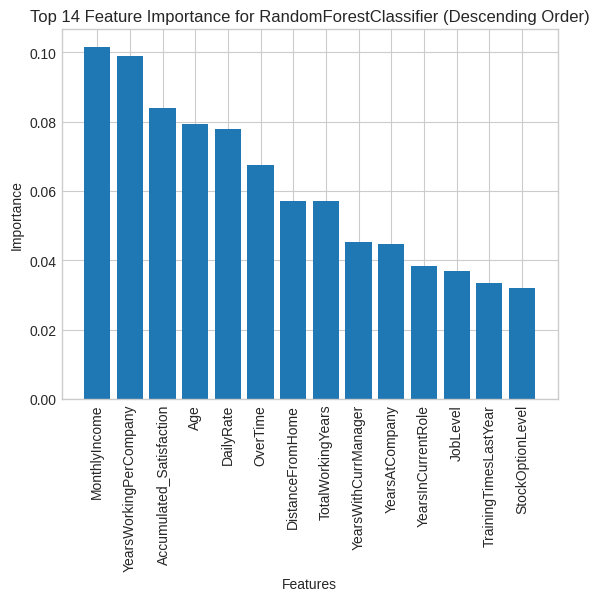

In [101]:
# Top 14 Feature Importance

selected_feature_indices = [list(X_train.columns).index(feature) for feature in selected_features.index]

X_train_selected = X_train_resampled[:, selected_feature_indices]

rf_params = {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50, 'criterion': 'gini'}
rf_model = RandomForestClassifier(**rf_params).fit(X_train_selected, y_train_resampled)

importance = rf_model.feature_importances_

sorted_indices = importance.argsort()[::-1]
sorted_importance = importance[sorted_indices]
sorted_features = selected_features.index[sorted_indices]

# Show only the top 14 feature importance values and features
num_top_features = 14
for i, (feature, score) in enumerate(zip(sorted_features[:num_top_features], sorted_importance[:num_top_features]), 1):
    print(f'{i}. Feature: {feature}, Score: {score:.5f}')

plt.bar(sorted_features[:num_top_features], sorted_importance[:num_top_features])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Top 14 Feature Importance for RandomForestClassifier (Descending Order)")
plt.show()

Menarik untuk dianalisis lebih lanjut, bahwa kedua fitur baru yang dihasilkan dari ekstraksi fitur-fitur yang sudah ada menempati posisi Top 3 feature importance. Selanjutnya kedua fitur ini menjadi objek menarik untuk ditelaah lebih lanjut untuk diberikan insight dan rekomendasi.

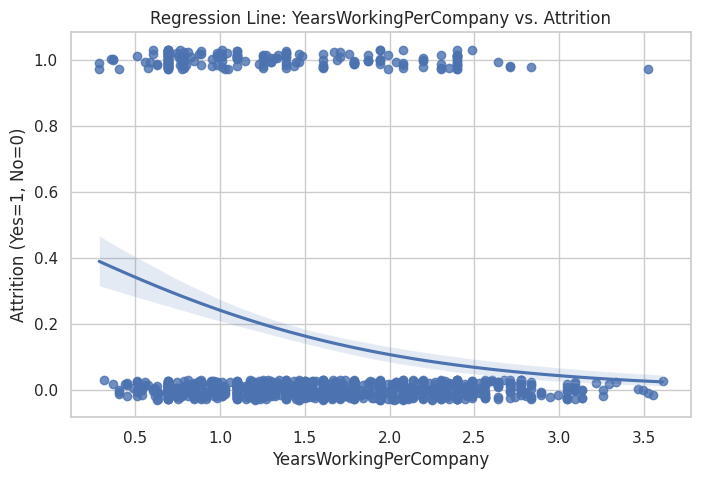

In [118]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Plotting the regression line
plt.figure(figsize=(8, 5))
sns.regplot(x='YearsWorkingPerCompany', y='Attrition', data=df, logistic=True, y_jitter=0.03)
plt.title("Regression Line: YearsWorkingPerCompany vs. Attrition")
plt.xlabel("YearsWorkingPerCompany")
plt.ylabel("Attrition (Yes=1, No=0)")
plt.show()

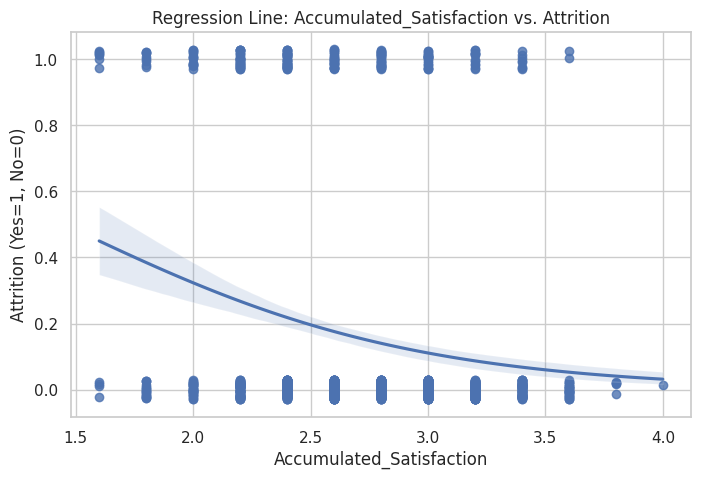

In [119]:
sns.set(style="whitegrid")

# Plotting the regression line
plt.figure(figsize=(8, 5))
sns.regplot(x='Accumulated_Satisfaction', y='Attrition', data=df, logistic=True, y_jitter=0.03)
plt.title("Regression Line: Accumulated_Satisfaction vs. Attrition")
plt.xlabel("Accumulated_Satisfaction")
plt.ylabel("Attrition (Yes=1, No=0)")
plt.show()

Grafik di atas menunjukkan bahwa hubungan antara YearsWorkingPerCompany dengan Attrition menunjukkan bahwa semakin besar nilai YearsWorkingPerCompany maka kecenderungan untuk Attrition akan menurun. Hal ini menjelaskan bahwa semakin besar nilai, semakin loyal karyawan tersebut. Dalam upaya meningkatkan loyalitas karyawan, diperlukan aksi nyata oleh perusahaan. Salah satunya dengan melihat fitur Accumulated_Satisfaction yang juga menunjukkan semakin tinggi angka kepuasan karyawan, semakin rendah kecenderungan Attrition dari karyawan itu sendiri. Oleh karena itu, aksi nyata peningkatan kepuasan karyawan secara bersamaan juga akan meningkatkan nilai loyalitas karyawan. Maka, rekomendasi aksi yang dapat dilakukan oleh perusahaan adalah yang berorientasi pada peningkatan faktor kepuasan akumulasi yaitu, Environment Satisfaction, Job Satisfaction, Job Involvement, Relationship Satisfaction dan Worklife Balance karyawan.

**Rekomendasi aksi/program:**
1. Environment Satisfaction:
   - To ensure that the compensation and benefits offered to employees are attractive in order to keep employee morale high. The role of
compensation and benefits is critical in hiring and retaining qualified and
talented employees. (Sinta, Azmieti K., Setiadi, B., Jumawan, Damayanti, Endah S. and Soehaditama, Josua Panatap. (2023). “Employee Retention Strategy: Analysis Path Career, Compensation Benefit, Organization Commitment & Reward
System”. Retrieved
from: https://journal.formosapublisher.org/index.php/eajmr/article/view/3672/3404. )

  - Uses various rewards or incentives to attract, keep
people and motivate them to achieve personal goals and goals organization.
(Sinta, Azmieti K., Setiadi, B., Jumawan, Damayanti, Endah S. and Soehaditama, Josua Panatap. (2023). “Employee Retention Strategy: Analysis Path Career, Compensation Benefit, Organization Commitment & Reward
System”. Retrieved
from: https://journal.formosapublisher.org/index.php/eajmr/article/view/3672/3404. )

2. Job Satisfaction:
   - Focus on training and development. Identifying the training need and giving appropriate training to the employees make them to enhance their skills and motivate them to reach higher positions.
   (Vetrivel, T., Ramesh, S. and M.S, Kamalaveni. (2019). “A REVIEW OF LITERATURE ON EMPLOYEE RETENTION”. Retrieved
from: https://www.researchgate.net/publication/335677274. )
  - It is essential to conduct a survey to measure the satisfaction level of employees in organizations. The reason
behind this is that this would help in understanding the satisfaction level of the employees and steps can be taken
to improve the satisfaction level. (Vetrivel, T., Ramesh, S. and M.S, Kamalaveni. (2019). “A REVIEW OF LITERATURE ON EMPLOYEE RETENTION”. Retrieved
from: https://www.researchgate.net/publication/335677274. )
  - A career path or career path is defined as a set of positions that each
employee must go through to reach a certain level of position within a company.  (Sinta, Azmieti K., Setiadi, B., Jumawan, Damayanti, Endah S. and Soehaditama, Josua Panatap. (2023). “Employee Retention Strategy: Analysis Path Career, Compensation Benefit, Organization Commitment & Reward
System”. Retrieved
from: https://journal.formosapublisher.org/index.php/eajmr/article/view/3672/3404. )
  - Security at work place especially in the case of women employees may help in retaining pool of women workforce. (Karumuri, Venkateswarlu and Singareddi, Sriprasanthi. (2014). “EMPLOYEE ATTRITION AND RETENTION: A THEORETICAL PERSPECTIVE”. Retrieved from: https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=8a8ba9c73f3e624032e71c31a3cbf1a94f935905. )
3. Job Involvement:
    - The management should consider the ideas and
opinions of employees while any decisions are taken with related to work and other
matter. Active participation of employees in the decision making process increases the
morale of the employee. (Karumuri, Venkateswarlu and Singareddi, Sriprasanthi. (2014). “EMPLOYEE ATTRITION AND RETENTION: A THEORETICAL PERSPECTIVE”. Retrieved
from: https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=8a8ba9c73f3e624032e71c31a3cbf1a94f935905. )

  - The employees can be empowered in their works by giving autonomy in performing their
jobs without more involvement of superiors. (Karumuri, Venkateswarlu and Singareddi, Sriprasanthi. (2014). “EMPLOYEE ATTRITION AND RETENTION: A THEORETICAL PERSPECTIVE”. Retrieved
from: https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=8a8ba9c73f3e624032e71c31a3cbf1a94f935905. )
  - To avoid monotony of work in some jobs, fun related activities, games, get together, stress management
programs can be organized. (Vetrivel, T., Ramesh, S. and M.S, Kamalaveni. (2019). “A REVIEW OF LITERATURE ON EMPLOYEE RETENTION”. Retrieved
from: https://www.researchgate.net/publication/335677274. )
4. Relationship Satisfaction:
   - Equality and fairness treatment among the employees would create a sense that everyone is treated as one and the same i.e. there is no bias among the employees. (Vetrivel, T., Ramesh, S. and M.S, Kamalaveni. (2019). “A REVIEW OF LITERATURE ON EMPLOYEE RETENTION”. Retrieved
from: https://www.researchgate.net/publication/335677274. )
  - It is highly important to conduct exit interview to identify the reasons behind leaving of employees in organizations. This would help in strengthening the strategies for employee retention. (Vetrivel, T., Ramesh, S. and M.S, Kamalaveni. (2019). “A REVIEW OF LITERATURE ON EMPLOYEE RETENTION”. Retrieved
from: https://www.researchgate.net/publication/335677274. )
  - Mutual trust between the employer and employee must be created so as to bring a feel that employees are part
of the organization and they are working not only for their benefit but also for the benefit of the organization
and as well as for the benefit of the society.  (Vetrivel, T., Ramesh, S. and M.S, Kamalaveni. (2019). “A REVIEW OF LITERATURE ON EMPLOYEE RETENTION”. Retrieved
from: https://www.researchgate.net/publication/335677274. )

5. Worklife Balance:
   - Work from home can be encouraged in organizations where there is no crèche facility which would boost the
morale of the female employees. (Vetrivel, T., Ramesh, S. and M.S, Kamalaveni. (2019). “A REVIEW OF LITERATURE ON EMPLOYEE RETENTION”. Retrieved
from: https://www.researchgate.net/publication/335677274. )
  - Fair and competitive salaries, performance related incentives may help in retaining the talented employees with the organization for a long period. (Karumuri, Venkateswarlu and Singareddi, Sriprasanthi. (2014). “EMPLOYEE ATTRITION AND RETENTION: A THEORETICAL PERSPECTIVE”. Retrieved
from: https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=8a8ba9c73f3e624032e71c31a3cbf1a94f935905.)



Reference:
1.  Vetrivel, T., Ramesh, S. and M.S, Kamalaveni. (2019). “A REVIEW OF LITERATURE ON EMPLOYEE RETENTION”. Retrieved
from: https://www.researchgate.net/publication/335677274.
2. Karumuri, Venkateswarlu and Singareddi, Sriprasanthi. (2014). “EMPLOYEE ATTRITION AND RETENTION: A THEORETICAL PERSPECTIVE”. Retrieved
from: https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=8a8ba9c73f3e624032e71c31a3cbf1a94f935905.
3. Sinta, Azmieti K., Setiadi, B., Jumawan, Damayanti, Endah S. and Soehaditama, Josua Panatap. (2023). “Employee Retention Strategy: Analysis Path Career, Compensation Benefit, Organization Commitment & Reward
System”. Retrieved
from: https://journal.formosapublisher.org/index.php/eajmr/article/view/3672/3404.
